Generating Delaunay Triangulation (DT)...
DT saved to ./DT_net/2keihan2_pop_1000_dt.net


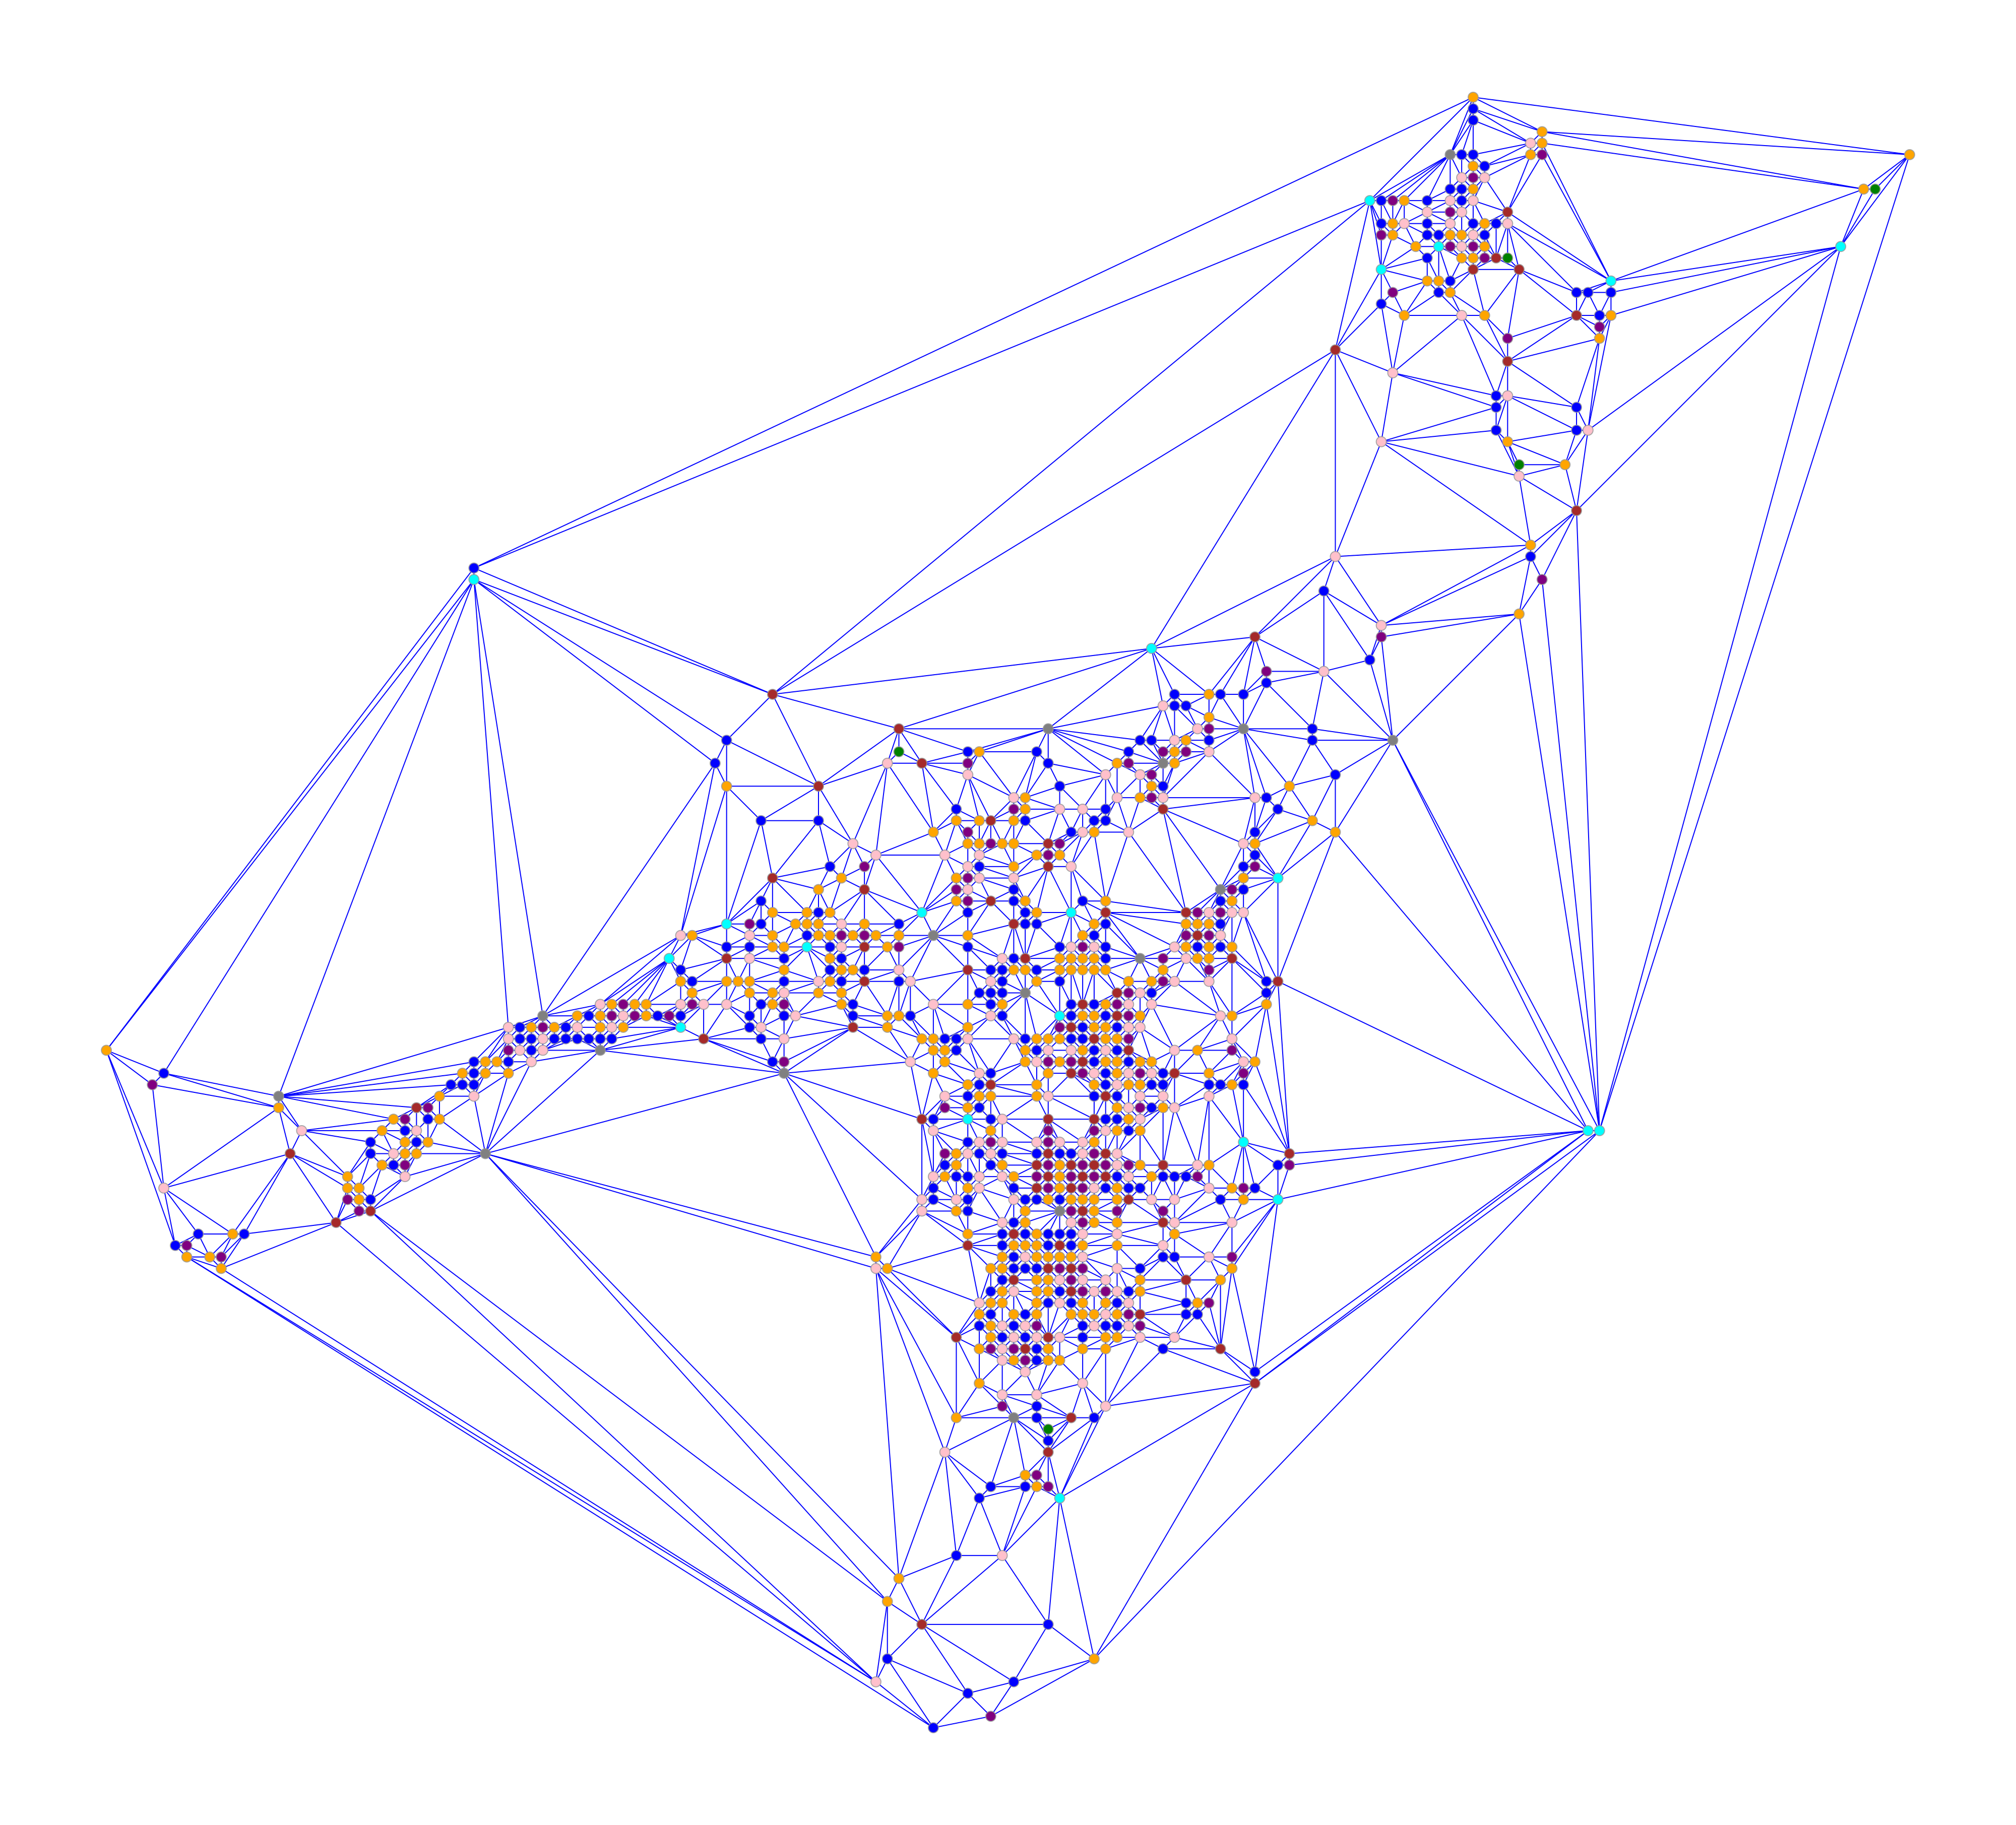

DT image saved to ./output/2keihan2_pop_1000_dt.png
Generating RNG...
RNG saved to ./RNG_net/2keihan2_pop_1000_rng.net


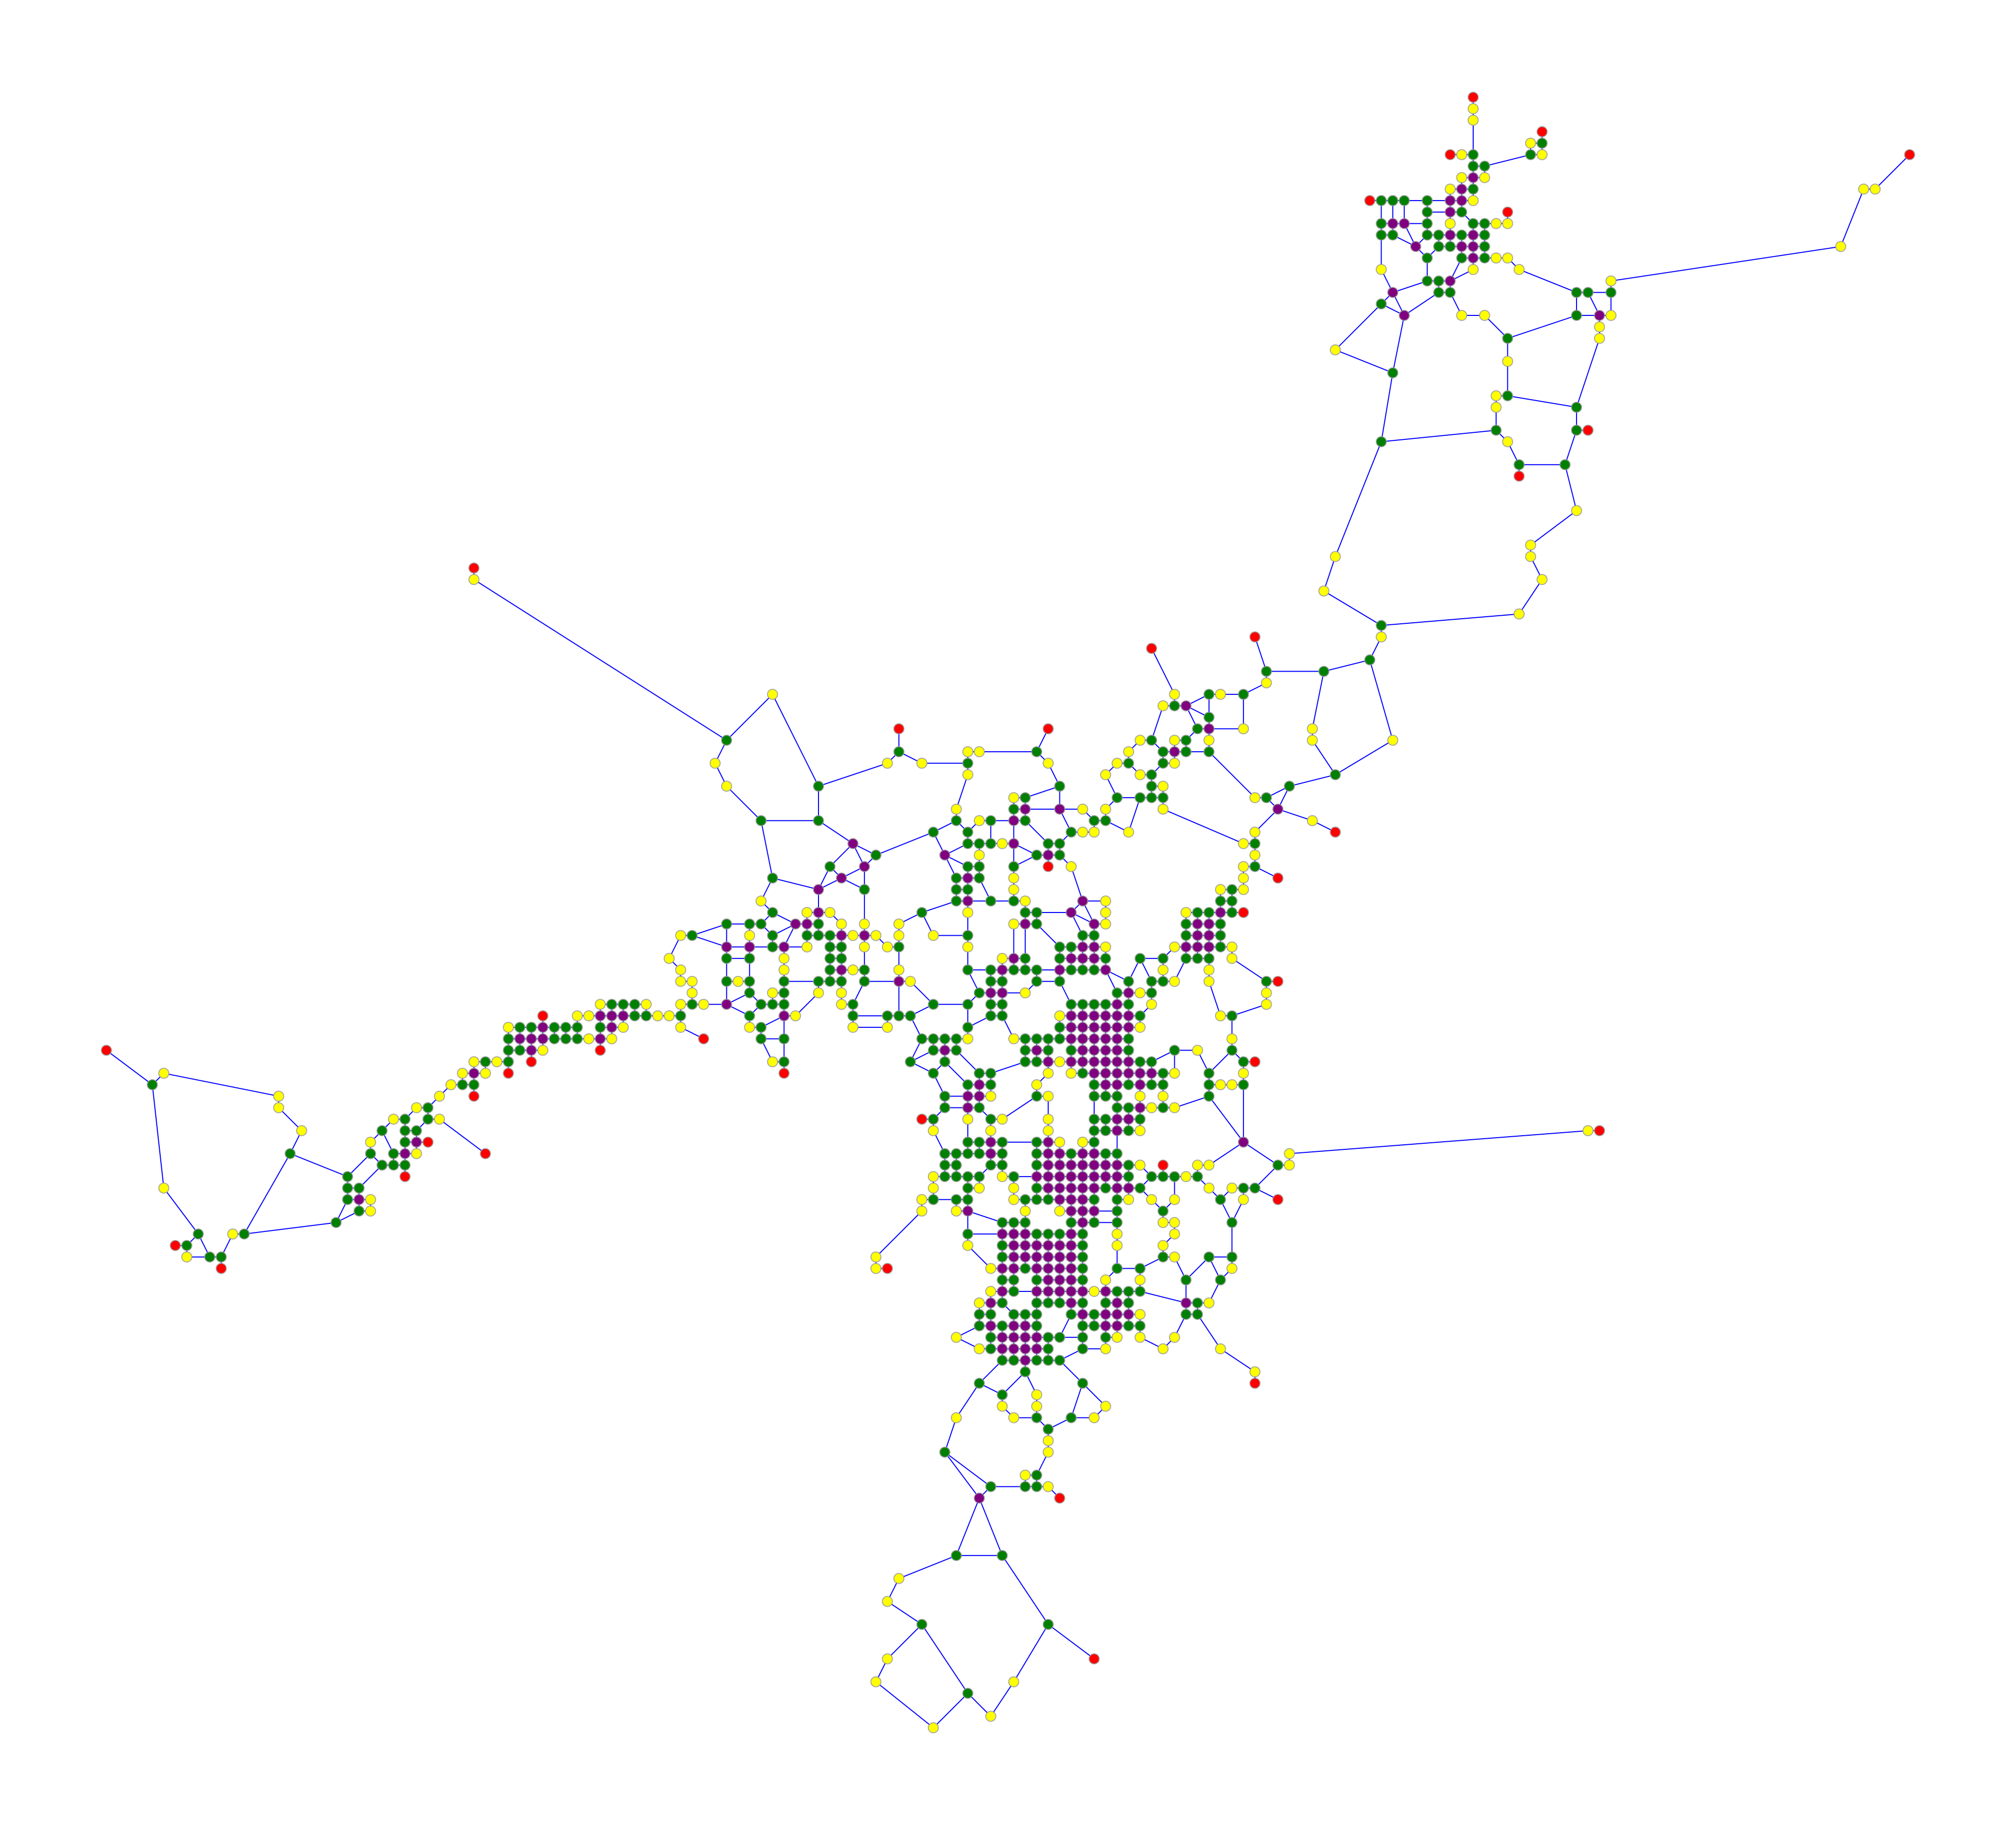

RNG image saved to ./output/2keihan2_pop_1000_rng.png
Generating GG...
GG saved to ./GG_net/2keihan2_pop_1000_gg.net


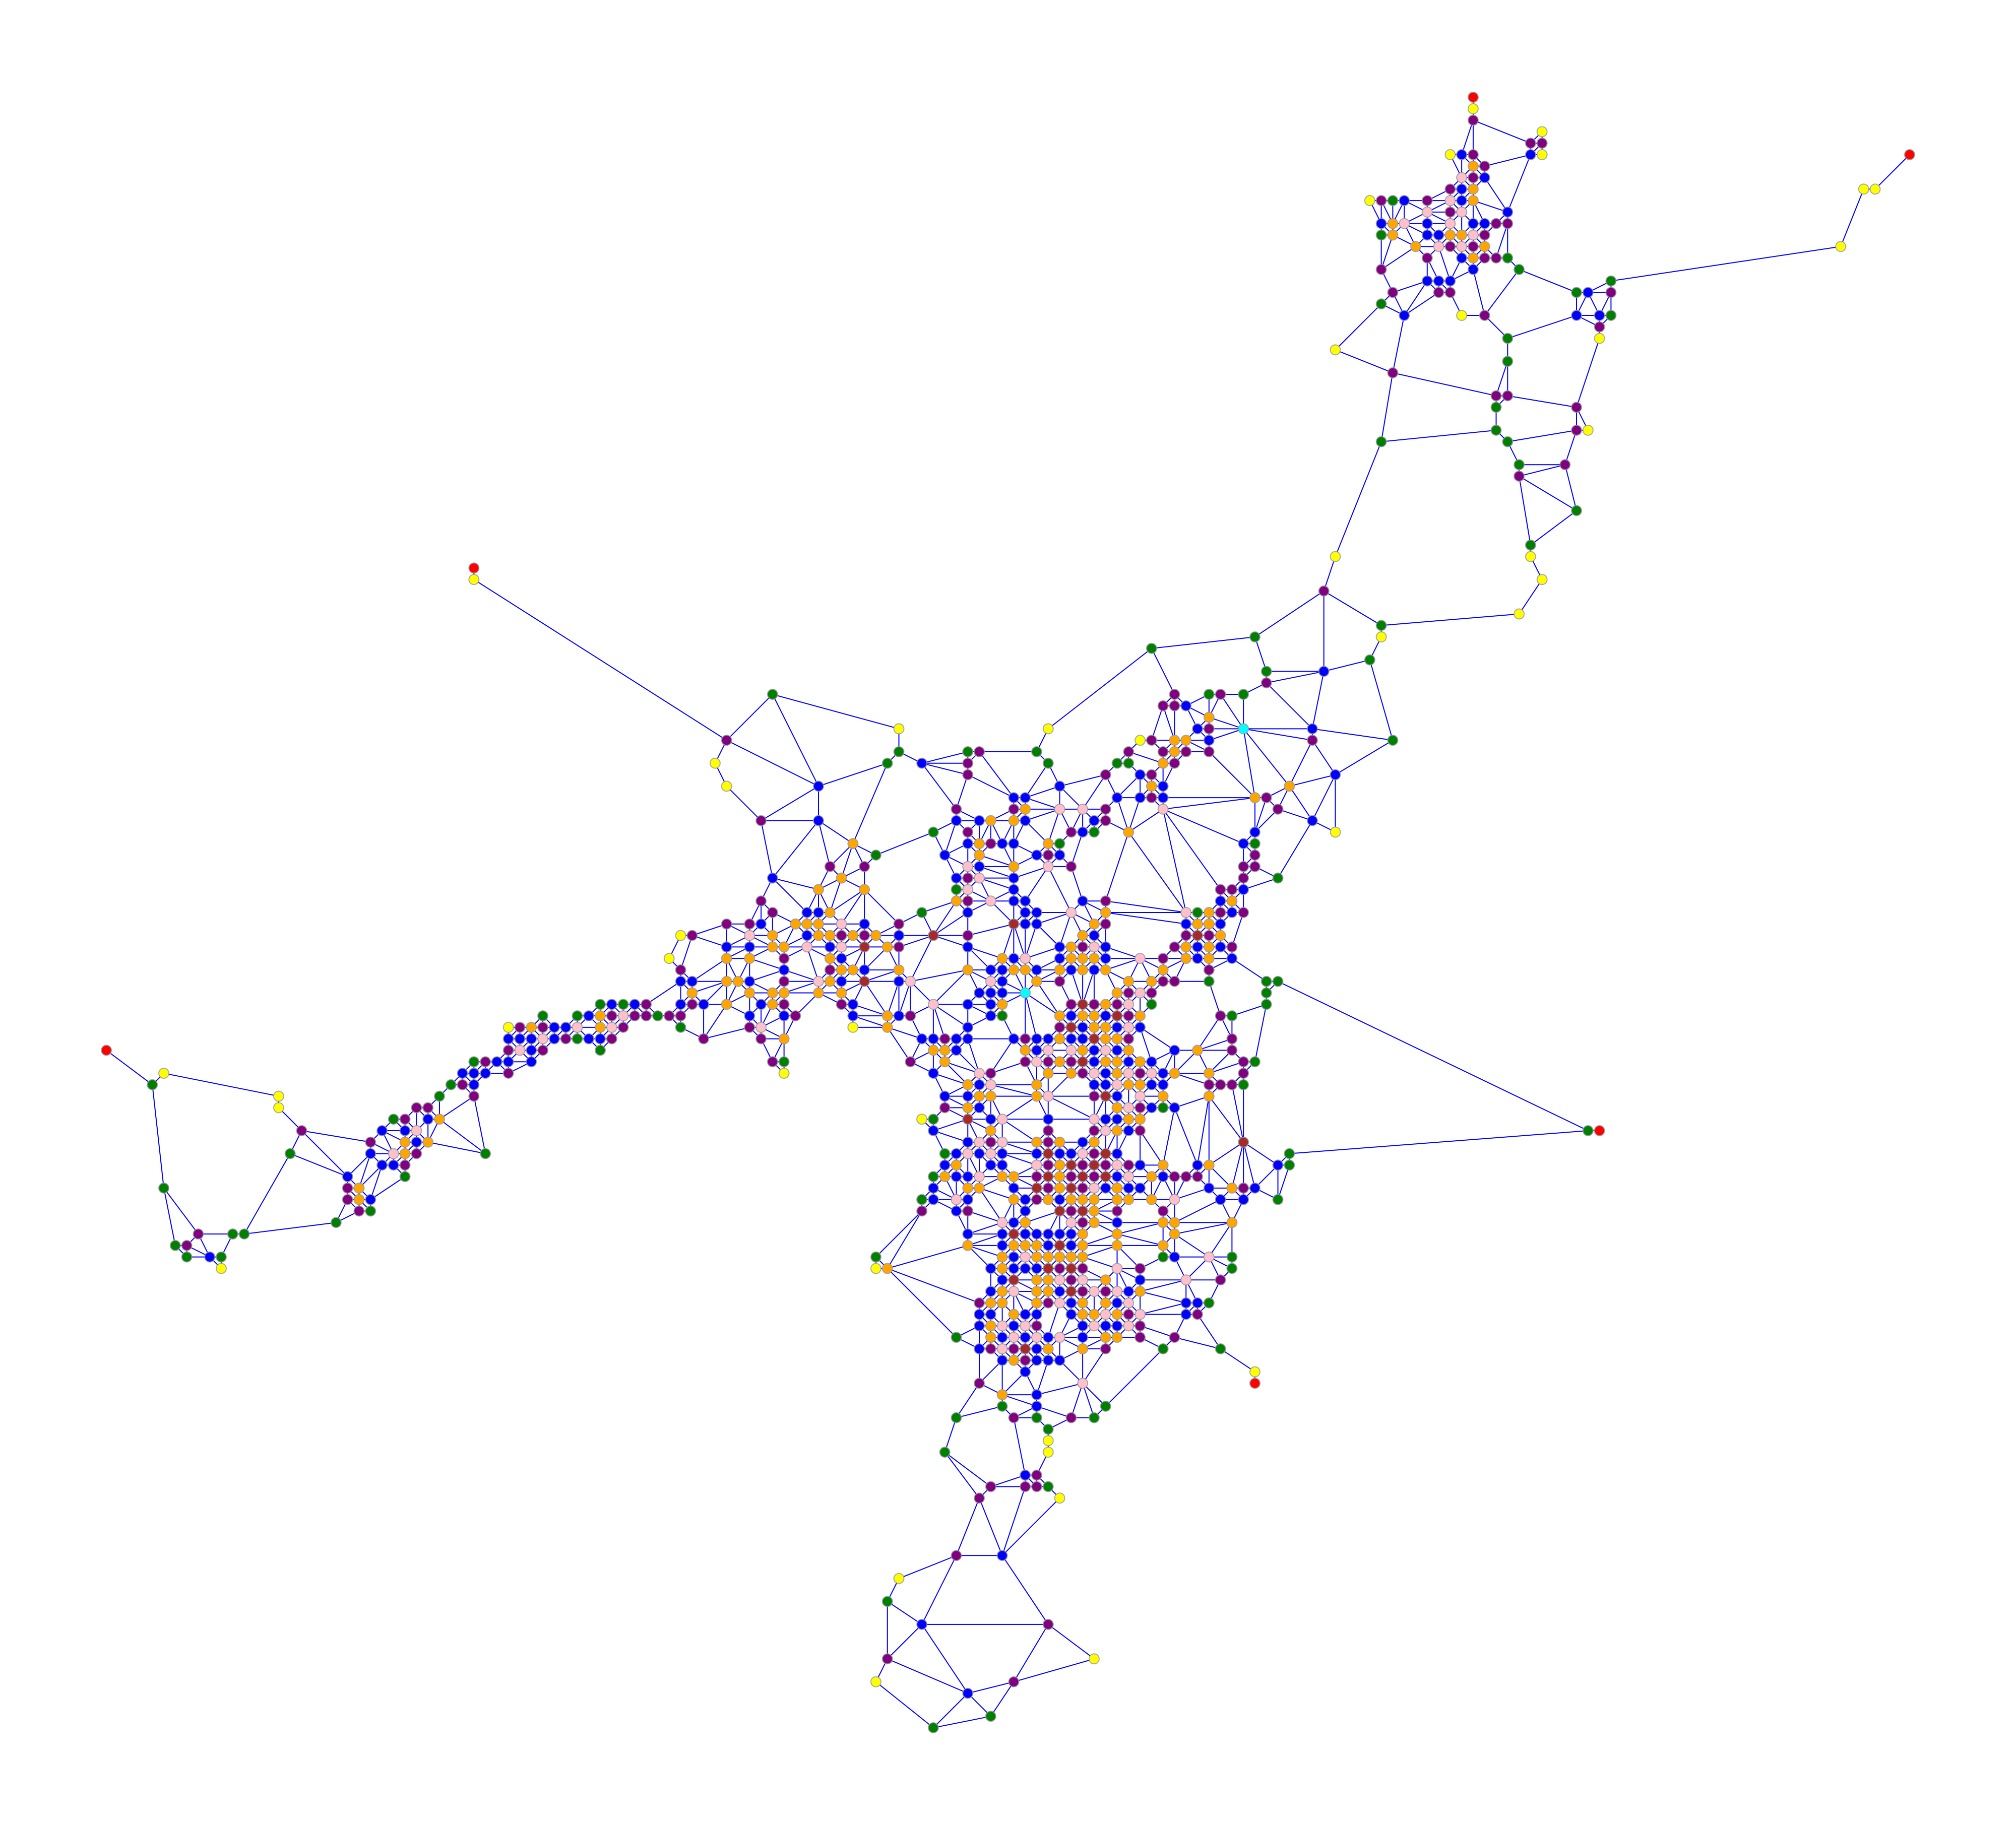

GG image saved to ./output/2keihan2_pop_1000_gg.png


In [14]:
from graph_tool.all import graph_draw, Graph
import numpy as np
from scipy.spatial import Delaunay
import python_codes.files_operators as fo

def euclidean_distance(pos1, pos2):
    """计算两个点之间的欧几里得距离"""
    return np.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

def generate_delaunay_graph(positions, graph):
    """
    生成德劳内三角剖分图（DT）
    :param positions: 节点的位置（graph_tool 的 VertexPropertyMap）
    :param graph: 原始图对象（用于获取顶点）
    :return: 基于 DT 的图对象
    """
    # 提取所有节点的位置
    points = np.array([np.array(positions[v]) for v in graph.vertices()])
    delaunay = Delaunay(points)
    dt_graph = Graph(directed=False)
    dt_graph.add_vertex(len(points))

    for simplex in delaunay.simplices:
        for i in range(3):
            u, v = simplex[i], simplex[(i + 1) % 3]
            if not dt_graph.edge(u, v):  # 避免重复添加边
                dt_graph.add_edge(u, v)

    return dt_graph

def generate_rng_from_dt(dt_graph, positions):
    """
    在德劳内三角剖分图的基础上生成 Relative Neighborhood Graph（RNG）
    :param dt_graph: 基于 DT 的图
    :param positions: 节点的位置
    :return: RNG 图
    """
    rng_graph = Graph(directed=False)
    rng_graph.add_vertex(dt_graph.num_vertices())

    for edge in dt_graph.edges():
        u, v = edge.source(), edge.target()
        uv_distance = euclidean_distance(positions[u], positions[v])
        valid_edge = True
        for w in dt_graph.vertices():
            if w == u or w == v:
                continue
            if euclidean_distance(positions[u], positions[w]) < uv_distance and \
               euclidean_distance(positions[v], positions[w]) < uv_distance:
                valid_edge = False
                break
        if valid_edge:
            rng_graph.add_edge(u, v)

    return rng_graph

def generate_gg_from_dt(dt_graph, positions):
    """
    在德劳内三角剖分图的基础上生成 Gabriel Graph（GG）
    :param dt_graph: 基于 DT 的图
    :param positions: 节点的位置
    :return: GG 图
    """
    gg_graph = Graph(directed=False)
    gg_graph.add_vertex(dt_graph.num_vertices())

    for edge in dt_graph.edges():
        u, v = edge.source(), edge.target()
        uv_distance = euclidean_distance(positions[u], positions[v])
        midpoint = [(positions[u][0] + positions[v][0]) / 2, (positions[u][1] + positions[v][1]) / 2]
        valid_edge = True
        for w in dt_graph.vertices():
            if w == u or w == v:
                continue
            if euclidean_distance(midpoint, positions[w]) < uv_distance / 2:
                valid_edge = False
                break
        if valid_edge:
            gg_graph.add_edge(u, v)

    return gg_graph

def add_vertex_properties(graph):
    """
    为图的节点添加 'number' 和 'color' 属性
    :param graph: 图对象
    """
    number_property = graph.new_vertex_property("int")
    color_property = graph.new_vertex_property("string")
    color_map = ['red', 'yellow', 'green', 'purple', 'blue', 'orange', 'pink', 'brown', 'cyan', 'gray']
    degrees = graph.get_total_degrees(graph.get_vertices())

    for v in graph.vertices():
        number_property[v] = int(v) + 1
        degree = int(degrees[int(v)])
        color_property[v] = color_map[min(degree - 1, len(color_map) - 1)]

    graph.vertex_properties['number'] = number_property
    graph.vertex_properties['color'] = color_property

def draw_and_save_graph(graph, positions, output_image, title):
    """
    绘制并保存图像
    :param graph: 图对象
    :param positions: 节点位置属性
    :param output_image: 图像保存路径
    :param title: 图像标题
    """
    vertex_colors = graph.vertex_properties['color']
    graph_draw(graph, pos=positions, vertex_size=10, edge_color='blue', vertex_fill_color=vertex_colors, output_size=(2000, 2000))
    graph_draw(graph, pos=positions, vertex_size=10, edge_color='blue', vertex_fill_color=vertex_colors, output_size=(2000, 2000), output=output_image)
    print(f"{title} image saved to {output_image}")

def process_rng_gg_with_dt(input_net, output_dt_net, output_rng_net, output_gg_net, dt_image, rng_image, gg_image):
    """
    根据输入 .net 文件生成 DT、RNG 和 GG 网络，并保存为 .net 文件与图像
    :param input_net: 输入 .net 文件路径
    :param output_dt_net: 输出 DT .net 文件路径
    :param output_rng_net: 输出 RNG .net 文件路径
    :param output_gg_net: 输出 GG .net 文件路径
    :param dt_image: DT 图像保存路径
    :param rng_image: RNG 图像保存路径
    :param gg_image: GG 图像保存路径
    """
    # 读取网络文件，仅获取节点位置
    graph, positions = fo.read_files(input_net, True)

    # 生成德劳内三角剖分图
    print("Generating Delaunay Triangulation (DT)...")
    dt_graph = generate_delaunay_graph(positions, graph)
    add_vertex_properties(dt_graph)
    fo.save_files(output_dt_net, dt_graph, positions, position_flag=True)
    print(f"DT saved to {output_dt_net}")
    draw_and_save_graph(dt_graph, positions, dt_image, "DT")

    # 生成 RNG
    print("Generating RNG...")
    rng_graph = generate_rng_from_dt(dt_graph, positions)
    add_vertex_properties(rng_graph)
    fo.save_files(output_rng_net, rng_graph, positions, position_flag=True)
    print(f"RNG saved to {output_rng_net}")
    draw_and_save_graph(rng_graph, positions, rng_image, "RNG")

    # 生成 GG
    print("Generating GG...")
    gg_graph = generate_gg_from_dt(dt_graph, positions)
    add_vertex_properties(gg_graph)
    fo.save_files(output_gg_net, gg_graph, positions, position_flag=True)
    print(f"GG saved to {output_gg_net}")
    draw_and_save_graph(gg_graph, positions, gg_image, "GG")


# 示例使用
city = '2keihan2'
scale = '1000'
input_net_file = f"./pop/{city}_{scale}_population.net"
output_dt_net_file = f"./DT_net/{city}_pop_{scale}_dt.net"
output_rng_net_file = f"./RNG_net/{city}_pop_{scale}_rng.net"
output_gg_net_file = f"./GG_net/{city}_pop_{scale}_gg.net"
output_dt_image = f"./output/{city}_pop_{scale}_dt.png"
output_rng_image = f"./output/{city}_pop_{scale}_rng.png"
output_gg_image = f"./output/{city}_pop_{scale}_gg.png"

process_rng_gg_with_dt(input_net_file, output_dt_net_file, output_rng_net_file, output_gg_net_file, output_dt_image, output_rng_image, output_gg_image)
